# Simple Integration Routine

In this notebook, we will go through the procedure of implementing a function, `integrate(fn, x0, t0, t1, dt)`, that integrates a function, `fn(x, t)`, from `t0` to `t1` in increments of `dt` using `x0` as the initial state.

We will implement the Euler method, demonstrate the Runge-Kutta 4 method and show how to implement this function in a way that is compatible with PyTorch's autograd framework in order to facilitate easy integration into a neural network pipeline 

In [1]:
# For plotting results
import matplotlib.pyplot as plt
import torch

In [2]:
# For convenience, we define the default tensor device and dtype here
torch.set_default_device('cpu')
# In neural networks, we prefer 32-bit/16-bit floats, but for precise integration, 64-bit is preferred. We will revisit this later when we need to mix integration with neural network training
torch.set_default_dtype(torch.float64) 

## Define `fn(x,t)`

First, we'll start with a simple test function, $\frac{dx}{dt}=1$ whose solution is known: $x(t)=x_0+t$ 

In [3]:
def simple_fn(x, t):
    """
    Derivative of a linear function.
    :param x: the current state
    :param t: the current time
    :return: the gradient at (x,t)
    """
    # We use torch.ones_like as x may be a multi-dimensional tensor
    # While PyTorch may correctly handle adding a simple scalar, it is good practice
    # to use the utilities provided by PyTorch
    return torch.ones_like(x)

def simple_fn_solution(initial_x, t):
    """
    Linear function initial_x+t
    :param initial_x: the initial state for the linear function
    :param t: the time at which the solution is desired
    :return: the state at time t
    """
    return initial_x + torch.ones_like(initial_x)*t

## Define `integrate(fn, x0, t0, t1, dt)`

Next, we need to write our integration routine. I find that, in a notebook environment like this one, it is easier to first write the code and then convert it into a function, that way it is easier to debug each step.

Thus, we'll first define our integration variables: the initial state, the initial time, the final time and the timestep.

In [4]:
x0 = torch.tensor([1.0])
t0 = torch.tensor(0.0)
t1 = torch.tensor(1.0)
N  = 10
dt = (t1 - t0) / N

The Euler method is quite simple, at each step, we take the result of the previous step and add to it the product of the timestep and the derivative.

$$
x_{n+1} = x_n + \frac{dx}{dt}(x_n, t_n)\Delta t \\
t_{n+1} = t_n + \Delta t
$$

In [5]:
# We don't want to modify the pre-existing state variables so we clone them
current_time = t0.clone()
current_state = x0.clone()

# We'd like to track the whole trajectory, not just the final state, so we use a list to store the intermediate states and times
intermediate_states = [(current_state.clone(), current_time.clone())]

# We integrate as long as the current_time is less than t1, the final time
while torch.any(current_time < t1):
    current_state = current_state + simple_fn(current_state, current_time)*dt
    current_time = current_time + dt
    intermediate_states.append((current_state.clone(), current_time.clone()))
    
print(f"Final time: {current_time}")
print(f"Final state: {current_state}")

Final time: 1.0999999999999999
Final state: tensor([2.1000])


Now you'll notice that the final time exceeds `t1`, why did this happen?

If you recall the discussion on finite precision in Introduction to ODEs, what's happened is that the accumulation of time values is inexact. The second-to-last timestep is at a time that is near indistinguishable from the final timestep, but due to the imprecision, the value is less than `t1`: 

In [6]:
print(f"Second-to-last time: {intermediate_states[-2][1].item():.16f}")
print(f"Target final time: {t1.item():.16f}")

Second-to-last time: 0.9999999999999999
Target final time: 1.0000000000000000


Due to this small difference, we end up taking one step too many and exceeding the final time.

To resolve this, we need to account for the difference. One solution is to check if we are within one timestep of the final time and then adjust the timestep for the final step. Alternatively, we could treat these time as equivalent by simply checking if they are close to each other within some tolerance. A final method would be to track the loss of precision using a complex summing routine like Kahan Summation.

The first leads to variation of timesteps that would not necessarily solve the problem if the difference is too small for the finite precision arithmetic (we end up with timesteps so small that adding them to the current time leads to no change). 

The second can lead to issues if we need to continue integration and find that we are not exactly at the time that we intended to be. This will be exacerbated by lower precision floating point types such as `float32` and `float16`.

The third is the most mathematically precise, but may not always solve the problem as adding too small a value can change nothing of the end result.

A combination of the first and third will lead to the most precise results and thus that will be our eventual implementation. For now, we will use the first method and avoid complexity.

Rewriting our loop we have:

In [7]:
# We don't want to modify the pre-existing state variables so we clone them
current_time = t0.clone()
current_state = x0.clone()

# We'd like to track the whole trajectory, not just the final state, so we use a list to store the intermediate states and times
intermediate_states = [(current_state.clone(), current_time.clone())]

# We integrate as long as the current_time+dt is less than t1
# Essentially, we want to stop the integration if taking another step
# would lead to exceeding the final time
while torch.any((current_time + dt) < t1):
    current_state = current_state + simple_fn(current_state, current_time)*dt
    current_time = current_time + dt
    intermediate_states.append((current_state.clone(), current_time.clone()))
current_state = current_state + simple_fn(current_state, current_time)*(t1 - current_time)
current_time = current_time + (t1 - current_time)
intermediate_states.append((current_state.clone(), current_time.clone()))
    
print(f"Final time: {current_time}")
print(f"Final state: {current_state}")

Final time: 1.0
Final state: tensor([2.0000])


Excellent, that seems to have resolved our issue in the expected fashion!

## Plotting results

First let's extract the times and the states from our list:

In [8]:
plot_times = [i[1].cpu().item() for i in intermediate_states]
plot_states = [i[0].cpu().item() for i in intermediate_states]

Then compute the ideal solution states at each time for comparison:

In [9]:
solution_states = [simple_fn_solution(x0, i[1]).cpu().item() for i in intermediate_states]

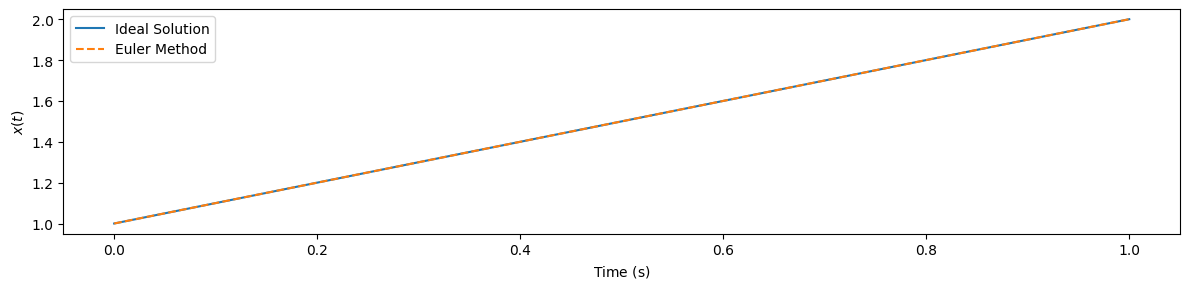

In [10]:
fig = plt.figure(figsize=(12, 3), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(plot_times, solution_states, label='Ideal Solution')
ax.plot(plot_times, plot_states, label='Euler Method', linestyle='--')
ax.set_xlabel(r'Time $(\mathrm{s})$')
ax.set_ylabel(r'$x(t)$')
ax.legend()

Amazing, the lines overlap exactly! Where did all the imprecision of the Euler method go?

Well, the Euler method _is_ exact for a constant derivative and therefore, regardless of step size, the solutions will overlap exactly (barring deviations due to floating-point imprecision). We can visualise this more clearly by looking at the error between the ideal and the euler solution:

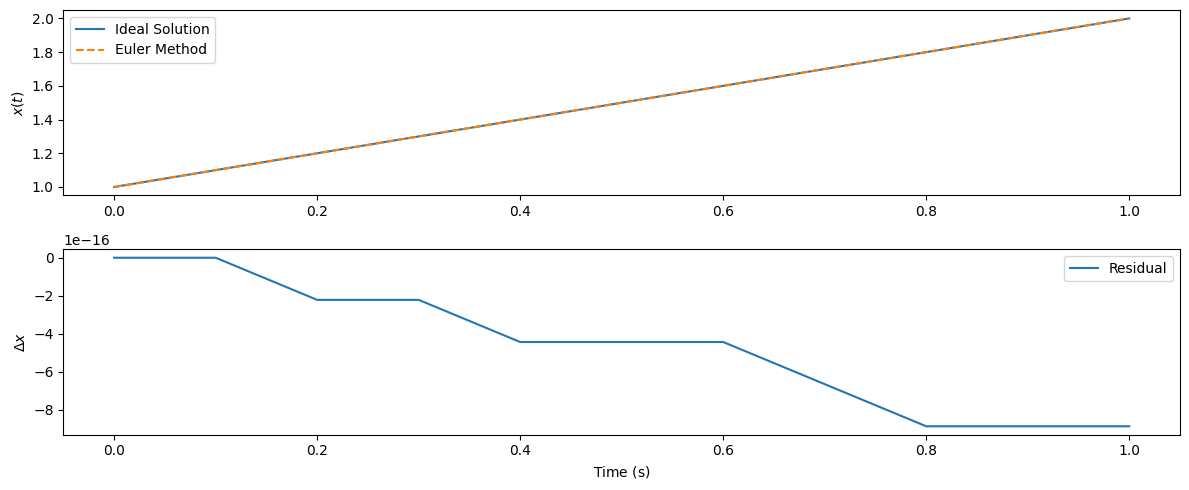

In [11]:
fig = plt.figure(figsize=(12, 5), tight_layout=True)
ax = fig.add_subplot(211)
ax.plot(plot_times, solution_states, label='Ideal Solution')
ax.plot(plot_times, plot_states, label='Euler Method', linestyle='--')
ax.set_ylabel(r'$x(t)$')
ax.legend()
ax = fig.add_subplot(212, sharex=ax)
ax.plot(plot_times, [(i - j) for i,j in zip(solution_states, plot_states)], label='Residual')
ax.set_xlabel(r'Time $(\mathrm{s})$')
ax.set_ylabel(r'$\Delta x$')
ax.legend()

### Wrapping up into one routine

Let's put all the euler method machinery into one function and look at how it behaves with different system. 

In [19]:
def integrate_euler(fn, initial_state, initial_time, final_time, timestep):
    """
    A general integration routine for solving an Initial Value Problem
    using the Euler Method
    :param fn: the function to be integrated
    :param initial_state: the initial state to integrate from
    :param initial_time: the initial time to integrate from
    :param final_time: the final time to integrate to
    :param timestep: the time increments to integrate with 
    :return: a tuple of ((the final state, the final time), the intermediates states [list]) 
    """
    # The names for the variables have been shortened for concision, and
    # to avoid overlap with variables in the outer scope
    # I have also left the annotations as they are invaluable for tracking the method. 
    c_time = initial_time.clone()
    c_state = initial_state.clone()
    
    # We'd like to track the whole trajectory, not just the final state, so we use a list to store the intermediate states and times
    i_states = [(c_state.clone(), c_time.clone())]
    
    # We integrate as long as the current_time+dt is less than t1
    # Essentially, we want to stop the integration if taking another step
    # would lead to exceeding the final time
    while torch.any((c_time + timestep) < final_time):
        c_state = c_state + fn(c_state, c_time)*timestep
        c_time = c_time + timestep
        i_states.append((c_state.clone(), c_time.clone()))
    c_state = c_state + fn(c_state, c_time)*(final_time - c_time)
    c_time = c_time + (final_time - c_time)
    i_states.append((c_state.clone(), c_time.clone()))
        
    return (c_state, c_time), i_states

Let's wrap the plotting into a single routine as well:

In [13]:
def plot_trajectory(initial_state, integration_states, ideal_solution_fn, axes=None, method_label="Euler Method"):
    plot_times = [i[1].cpu().item() for i in integration_states]
    plot_states = [i[0].cpu().item() for i in integration_states]
    solution_states = [ideal_solution_fn(initial_state, i[1]).cpu().item() for i in integration_states]
    
    if axes is None:
        fig = plt.figure(figsize=(12, 5), tight_layout=True)
        axes = []
    else:
        fig = axes[0].get_figure()
    
    if len(axes) < 2:
        ax = fig.add_subplot(211)
        axes.append(ax)
    else:
        ax = axes[0]
    ax.plot(plot_times, solution_states, label='Ideal Solution')
    ax.plot(plot_times, plot_states, label=method_label, linestyle='--')
    ax.set_ylabel(r'$x(t)$')
    ax.legend()
    if len(axes) < 2:
        ax = fig.add_subplot(212, sharex=ax)
        axes.append(ax)
    else:
        ax = axes[1]
    ax.plot(plot_times, [abs(i - j) for i,j in zip(solution_states, plot_states)], label=f'{method_label} Residual')
    ax.set_xlabel(r'Time $(\mathrm{s})$')
    ax.set_ylabel(r'$\Delta x$')
    ax.legend()
    return fig, axes

And let's test that the integration routine works as expected

(<Figure size 1200x500 with 2 Axes>,
 [<Axes: ylabel='$x(t)$'>,
  <Axes: xlabel='Time $(\\mathrm{s})$', ylabel='$\\Delta x$'>])

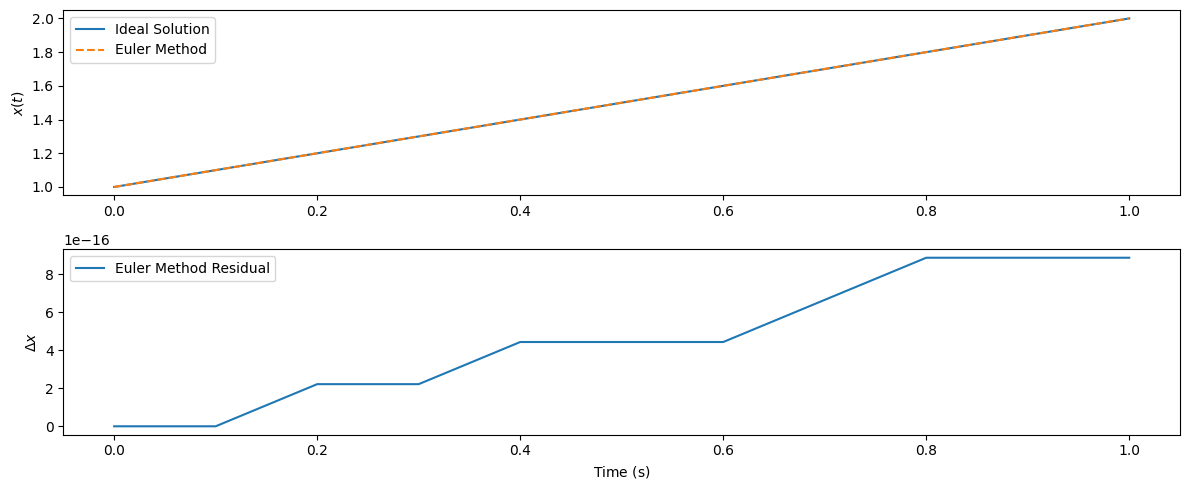

In [14]:
(f_state, f_time), sub_states = integrate_euler(simple_fn, x0, t0, t1, dt)

plot_trajectory(x0, sub_states, simple_fn_solution)

## A more complex system

Let's now increase the complexity of our system by adding a dependency on `x`. A simple such system is 
$$
x(t)=x_0\exp\left[-t\right] \\
\frac{dx}{dt}(x,t)=-x
$$

In [15]:
def exponential_fn(x, t):
    """
    The derivative of an exponential system
    :param x: the current state of the system
    :param t: the current time of the system
    :return: the derivative of the exponential system at (x,t)
    """
    return -x

def exponential_fn_solution(initial_state, t):
    """
    The solution of an exponentially decaying system
    :param initial_state: the initial state of the systme
    :param t: the time at which the solution is desired
    :return: the state at time t
    """
    return initial_state*torch.exp(-t)

(<Figure size 1200x500 with 2 Axes>,
 [<Axes: ylabel='$x(t)$'>,
  <Axes: xlabel='Time $(\\mathrm{s})$', ylabel='$\\Delta x$'>])

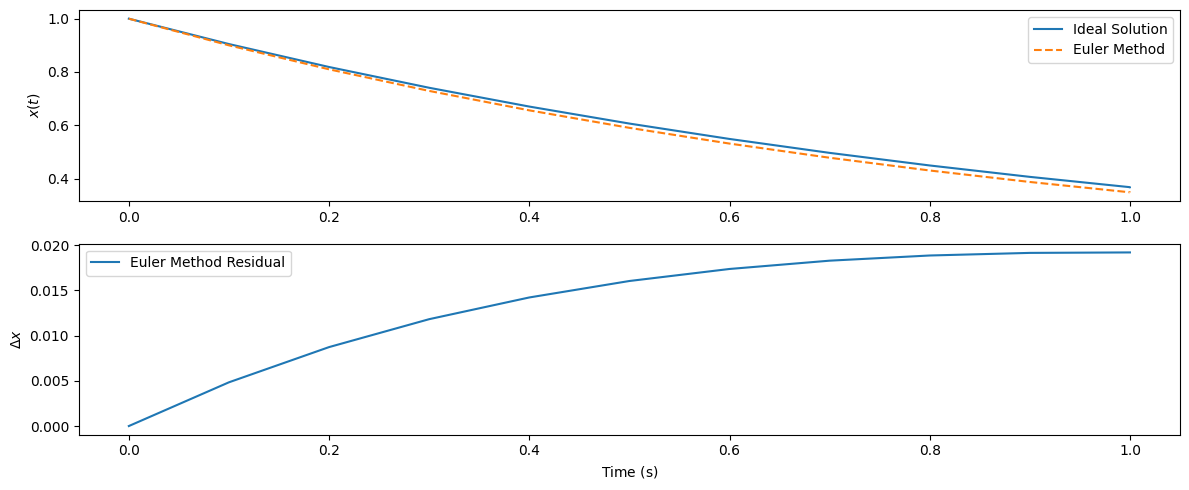

In [16]:
(f_state, f_time), sub_states = integrate_euler(exponential_fn, x0, t0, t1, dt)

plot_trajectory(x0, sub_states, exponential_fn_solution, method_label="Euler Method")

As we can see, the euler method diverges from the true solution quite quickly. Let's look at how the error at the final state changes as we vary the step size:

In [17]:
(final_state_full_step, final_time_full_step), _ = integrate_euler(exponential_fn, x0, t0, t1, dt)
(final_state_half_step, final_time_half_step), _ = integrate_euler(exponential_fn, x0, t0, t1, dt/2)
true_final_state = exponential_fn_solution(x0, t1)

error_in_full_step = (final_state_full_step - true_final_state).abs()
error_in_half_step = (final_state_half_step - true_final_state).abs()

print(f"Error in Full Step (Euler): {error_in_full_step.item()}")
print(f"Error in Half Step (Euler): {error_in_half_step.item()}")
print(f"Improvement in Error (Euler): {(error_in_full_step/error_in_half_step).item()}")

Error in Full Step (Euler): 0.019201001071442403
Error in Half Step (Euler): 0.00939351876290001
Improvement in Error (Euler): 2.04406906039059


From this we see that the error improvement is linear in the timestep, halving the timestep roughly halves the error. If we'd like to achieve an error on the order of machine precision, in this case float64, we would need to reduce the step until the error is on the order of ${10}^{-16}$ which is the smallest delta representable by float64.

Fortunately, PyTorch provides utilities for extracting this value, and assuming linear error reduction and our initial error, we can compute the step size we need: 

In [18]:
machine_precision_dt = dt * (torch.finfo(torch.float64).eps/error_in_full_step.item())
print(f"Timestep for machine precision (Euler): {machine_precision_dt}")

Timestep for machine precision (Euler): 1.156422022470889e-15


A timestep of that size, implies  $(t_1-t_0)/dt=1/dt\sim{10}^{15}$ steps, inordinately many steps to achieve high precision results. To that end, we need to introduce higher order integration schemes.

Let's start with a simple fourth-order scheme: The Classical Fourth-Order Method

## The Classical Fourth-Order Method

The Classical Fourth-Order Method has four stages, using the butcher tableau notation, we can write it as:

$$
\begin{array}{c|c}
0 \\
0.5 & 0.5 \\
0.5 & 0.0 & 0.5\\
1.0 & 0.0 & 0.0 & 1.0 \\
\hline
& 0.1\bar{6} & 0.3\bar{3} & 0.3\bar{3} & 0.1\bar{6} \\
\end{array}
$$

We take the same function from before, and modify it to account for the intermediate stages:

In [20]:
def integrate_runge_kutta_4(fn, initial_state, initial_time, final_time, timestep):
    """
    A general integration routine for solving an Initial Value Problem
    using the Classical Fourth-Order Method
    :param fn: the function to be integrated
    :param initial_state: the initial state to integrate from
    :param initial_time: the initial time to integrate from
    :param final_time: the final time to integrate to
    :param timestep: the time increments to integrate with 
    :return: a tuple of ((the final state, the final time), the intermediates states [list]) 
    """
    # The names for the variables have been shortened for concision, and
    # to avoid overlap with variables in the outer scope
    # I have also left the annotations as they are invaluable for tracking the method. 
    c_time = initial_time.clone()
    c_state = initial_state.clone()
    
    # We'd like to track the whole trajectory, not just the final state, so we use a list to store the intermediate states and times
    i_states = [(c_state.clone(), c_time.clone())]
    
    # We write out the butcher tableau for easier computation
    butcher_tableau = torch.tensor([
        # c0, a00, a01, a02, a03
        [0.0, 0.0, 0.0, 0.0, 0.0],
        # c1, a10, a11, a12, a13
        [0.5, 0.5, 0.0, 0.0, 0.0],
        # c2, a20, a21, a22, a23
        [0.5, 0.0, 0.5, 0.0, 0.0],
        # c3, a30, a31, a32, a33
        [1.0, 0.0, 0.0, 1.0, 0.0],
        #     b0,  b1,  b2,  b3
        [0.0, 1/6, 2/6, 2/6, 1/6]
    ], dtype=initial_state.dtype, device=initial_state.device)
    # We see here that this method of writing out the tableau, while complete,
    # is inefficient given that so many entries are zero.
    # Ideally, we would have a more compressed format, but for our purposes,
    # this works.
    
    # At each step we repeat the same procedure with differing states and times 
    # (and step sizes for the last step), thus it makes sense to 
    # wrap everything in a local function which can be called repeatedly.
    def compute_step(state, time, step):
        # We need to store the intermediate stages
        k_stages = torch.stack([torch.zeros_like(time)]*(butcher_tableau.shape[1] - 1))
        # we subtract one since the last row is the final state
        for stage_index in range(butcher_tableau.shape[0] - 1):
            c_coeff, *a_coeff = butcher_tableau[stage_index]
            k_stages[stage_index] = fn(
                state + step * sum(k*a for k,a in zip(k_stages, a_coeff)), 
                time + c_coeff * step
            )
        return state + step * sum(k*b for k,b in zip(k_stages, butcher_tableau[-1, 1:])), time + step
    
    # We integrate as long as the current_time+dt is less than t1
    # Essentially, we want to stop the integration if taking another step
    # would lead to exceeding the final time
    while torch.any((c_time + timestep) < final_time):
        c_state, c_time = compute_step(c_state, c_time, timestep)
        i_states.append((c_state.clone(), c_time.clone()))
    c_state, c_time = compute_step(c_state, c_time, final_time - c_time)
    i_states.append((c_state.clone(), c_time.clone()))
    
    return (c_state, c_time), i_states

In [21]:
(final_state_euler, final_time_euler), _ = integrate_euler(exponential_fn, x0, t0, t1, dt)
(final_state_rk4, final_time_rk4), _ = integrate_runge_kutta_4(exponential_fn, x0, t0, t1, dt)
true_final_state = exponential_fn_solution(x0, t1)

error_in_euler = (final_state_euler - true_final_state).abs()
error_in_rk4 = (final_state_rk4 - true_final_state).abs()

print(f"Error in Euler: {error_in_euler.item()}")
print(f"Error in RK4: {error_in_rk4.item()}")
print(f"Improvement in Error: {(error_in_euler/error_in_rk4).item()}")

Error in Euler: 0.019201001071442403
Error in RK4: 3.332410560275001e-07
Improvement in Error: 57618.953979841775


We see that the 4th order method shows significantly less error than the Euler method for the same timestep. Furthermore, we can see how the error scales as a function of the timestep:

In [22]:
(final_state_full_step, final_time_full_step), _ = integrate_runge_kutta_4(exponential_fn, x0, t0, t1, dt)
(final_state_half_step, final_time_half_step), _ = integrate_runge_kutta_4(exponential_fn, x0, t0, t1, dt/2)
true_final_state = exponential_fn_solution(x0, t1)

exponential_fn_solution(x0, t1)

error_in_full_step = (final_state_full_step - true_final_state).abs()
error_in_half_step = (final_state_half_step - true_final_state).abs()

print(f"Error in Full Step (RK4): {error_in_full_step.item()}")
print(f"Error in Half Step (RK4): {error_in_half_step.item()}")
print(f"Improvement in Error (RK4): {(error_in_full_step/error_in_half_step).item()}")

Error in Full Step (RK4): 3.332410560275001e-07
Error in Half Step (RK4): 1.9976097442864216e-08
Improvement in Error (RK4): 16.68198991222578


Incredible! Halving the timestep improved our results by a factor of 16, this is exactly as expected of a fourth order method where the error should improve proportional to the fourth power of the step size.

Plotting the same curves as before, we can see how the error varies over the integration time:

(<Figure size 1200x500 with 2 Axes>,
 [<Axes: ylabel='$x(t)$'>,
  <Axes: xlabel='Time $(\\mathrm{s})$', ylabel='$\\Delta x$'>])

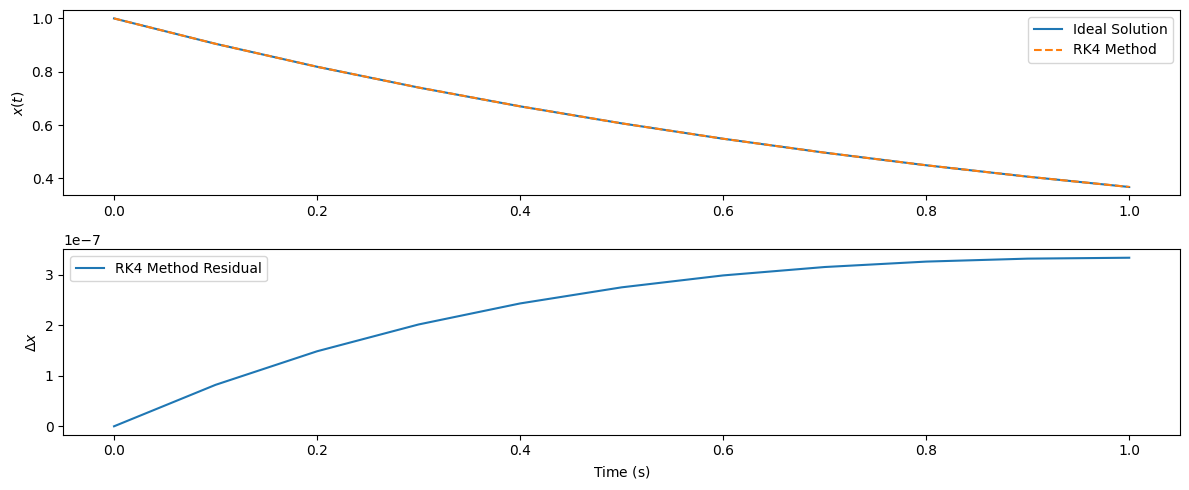

In [23]:
(f_state, f_time), sub_states = integrate_runge_kutta_4(exponential_fn, x0, t0, t1, dt)

plot_trajectory(x0, sub_states, exponential_fn_solution, method_label="RK4 Method")

Reducing the error down to machine precision now requires a more reasonable number of steps:

In [24]:
machine_precision_dt = dt * (torch.finfo(torch.float64).eps/error_in_full_step.item())**(1/4)
print(f"Timestep for machine precision (RK4): {machine_precision_dt}")

Timestep for machine precision (RK4): 0.0005080663487927019


Error in Machine Precision Step (RK4): 1.4210854715202004e-14


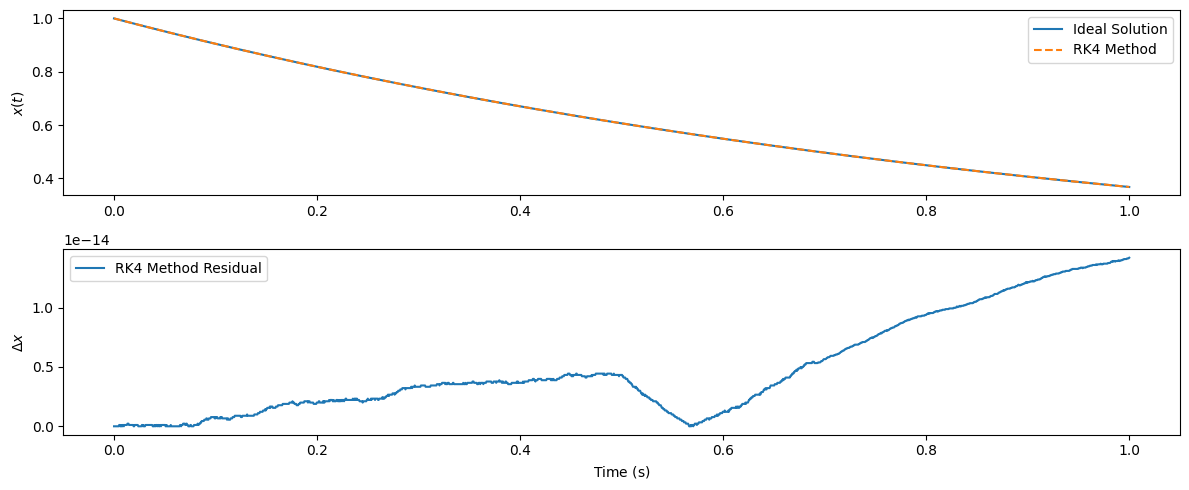

In [25]:
(f_state, f_time), sub_states = integrate_runge_kutta_4(exponential_fn, x0, t0, t1, machine_precision_dt)

plot_trajectory(x0, sub_states, exponential_fn_solution, method_label="RK4 Method")

print(f"Error in Machine Precision Step (RK4): {(f_state - exponential_fn_solution(x0, t1)).abs().item()}")

While the error achieved is on the order of machine precision, the error now shows a very different behaviour than before. Instead of decaying to a constant negative value, it appears to move randomly.

More precisely, the error is now no longer a correlated function of the integral but rather what is referred to as a Random Walk where the changes in the error can be modelled as a stochastic process.

This occurs due to the two competing sources of error in our computation: The imprecision of the integration scheme and the finite precision of the underlying arithmetic type. Having improved the former to its limits, the latter now becomes the dominant source of error.

Theoretically, this error can be reduced by using a compensated summation scheme where we track the truncated bits in the arithmetic and reintroduce them at each step. In practice, this yields only a modest improvement in results.

Kahan Summation is a compensated summation scheme that tracks truncated bits in the sum, it takes advantage of the order of operations to estimate these bits and then reintroduces them into the sum.

The variant we'll implement is the Kahan-Babuška-Neumaier algorithm, it takes into account the magnitude of the terms and accounts for which terms bits are truncated.

In [28]:
def compensated_sum(iterable_to_sum):
    """
    Functional equivalent to the python function `sum` but
    uses the Kahan-Babuška-Neumaier scheme to track truncated bits.
    
    Usage is the same as `sum`, but only works with pytorch tensors.
    
    References:
        [1] https://en.wikipedia.org/wiki/Kahan_summation_algorithm#Further_enhancements
    
    :param iterable_to_sum: any kind of iterable including generators that returns tensors
    :return: the compensated sum
    """
    partial_sum = None
    truncated_bits = None
    for v in iterable_to_sum:
        if partial_sum is None:
            partial_sum = torch.zeros_like(v)
            truncated_bits = torch.zeros_like(v)
        temporary_partial_sum = partial_sum + v
        truncated_bits = truncated_bits + torch.where(
            torch.abs(partial_sum) >= torch.abs(v),       # When the magnitude of the partial sum is larger, truncation occurs for v and vice versa when v is larger
            (partial_sum - temporary_partial_sum) + v,    # First the negation of the truncated value of v is computed from the partial sum and the temporary partial sum, and then adding it to v gives the truncated bits
            (v - temporary_partial_sum) + partial_sum     # As before, but the role of v and partial_sum are swapped
        )
        partial_sum = temporary_partial_sum
    return partial_sum + truncated_bits                   # Add truncated bits back to the sum

In [29]:
def integrate_runge_kutta_4_compensated(fn, initial_state, initial_time, final_time, timestep):
    """
    A general integration routine for solving an Initial Value Problem
    using the Classical Fourth-Order Method.
    
    Instead of naively summing the changes, we use compensated summation.
    
    :param fn: the function to be integrated
    :param initial_state: the initial state to integrate from
    :param initial_time: the initial time to integrate from
    :param final_time: the final time to integrate to
    :param timestep: the time increments to integrate with 
    :return: a tuple of ((the final state, the final time), the intermediates states [list]) 
    """
    # The names for the variables have been shortened for concision, and
    # to avoid overlap with variables in the outer scope
    # I have also left the annotations as they are invaluable for tracking the method. 
    c_time = initial_time.clone()
    c_state = initial_state.clone()
    
    # We'd like to track the whole trajectory, not just the final state, so we use a list to store the intermediate states and times
    i_states = [(c_state.clone(), c_time.clone())]
    
    # We write out the butcher tableau for easier computation
    butcher_tableau = torch.tensor([
        # c0, a00, a01, a02, a03
        [0.0, 0.0, 0.0, 0.0, 0.0],
        # c1, a10, a11, a12, a13
        [0.5, 0.5, 0.0, 0.0, 0.0],
        # c2, a20, a21, a22, a23
        [0.5, 0.0, 0.5, 0.0, 0.0],
        # c3, a30, a31, a32, a33
        [1.0, 0.0, 0.0, 1.0, 0.0],
        #     b0,  b1,  b2,  b3
        [0.0, 1/6, 2/6, 2/6, 1/6]
    ], dtype=initial_state.dtype, device=initial_state.device)
    # We see here that this method of writing out the tableau, while complete,
    # is inefficient given that so many entries are zero.
    # Ideally, we would have a more compressed format, but for our purposes,
    # this works.
    
    # At each step we repeat the same procedure with differing states and times 
    # (and step sizes for the last step), thus it makes sense to 
    # wrap everything in a local function which can be called repeatedly.
    def compute_step(state, time, step):
        # We need to store the intermediate stages
        k_stages = torch.stack([torch.zeros_like(time)]*(butcher_tableau.shape[1] - 1))
        # we subtract one since the last row is the final state
        for stage_index in range(butcher_tableau.shape[0] - 1):
            c_coeff, *a_coeff = butcher_tableau[stage_index]
            k_stages[stage_index] = fn(
                # We use `compensated_sum` instead of sum in order to avoid truncation at each stage calculation
                state + step * compensated_sum(k*a for k,a in zip(k_stages, a_coeff)), 
                time + c_coeff * step
            )
        # We return the change in the state and the change in the time as we track partial sums
        # Again, we use `compensated_sum` to avoid truncation in the final stage calculations
        return step * compensated_sum(k*b for k,b in zip(k_stages, butcher_tableau[-1, 1:])), step
    
    # Initialise compensated sum terms
    # We don't need the partial sum variable as `c_state` and `c_time` take on that role
    truncated_bits_state = torch.zeros_like(c_state)
    truncated_bits_time  = torch.zeros_like(c_time)
    
    # We integrate as long as the current_time+dt is less than t1
    # Essentially, we want to stop the integration if taking another step
    # would lead to exceeding the final time
    while torch.any((c_time + timestep) < final_time):
        # To compute the change in state, we add the truncated bits back
        delta_state, delta_time = compute_step(c_state + truncated_bits_state, c_time + truncated_bits_time, timestep)
        
        temporary = c_state + delta_state, c_time + delta_time
        truncated_bits_state = truncated_bits_state + torch.where(
            torch.abs(c_state) >= torch.abs(delta_state),
            (c_state - temporary[0]) + delta_state,
            (delta_state - temporary[0]) + c_state
        )
        truncated_bits_time = truncated_bits_time + torch.where(
            torch.abs(c_time) >= torch.abs(delta_time),
            (c_time - temporary[1]) + delta_time,
            (delta_time - temporary[1]) + c_time
        )
        c_state, c_time = temporary
        # We would like to store the intermediate states with the compensated partial sums
        i_states.append((c_state + truncated_bits_state, c_time + truncated_bits_time))
    delta_state, delta_time = compute_step(c_state + truncated_bits_state, c_time + truncated_bits_time, final_time - (c_time + truncated_bits_time))
    temporary = c_state + delta_state, c_time + delta_time
    truncated_bits_state = truncated_bits_state + torch.where(
        torch.abs(c_state) >= torch.abs(delta_state),
        (c_state - temporary[0]) + delta_state,
        (delta_state - temporary[0]) + c_state
    )
    truncated_bits_time = truncated_bits_time + torch.where(
        torch.abs(c_time) >= torch.abs(delta_time),
        (c_time - temporary[1]) + delta_time,
        (delta_time - temporary[1]) + c_time
    )
    c_state, c_time = temporary
    c_state, c_time = c_state + truncated_bits_state, c_time + truncated_bits_time
    i_states.append((c_state.clone(), c_time.clone()))
    
    return (c_state, c_time), i_states

Error in Machine Precision Step (RK4): 1.4210854715202004e-14
Error in Machine Precision Step (RK4): 2.220446049250313e-16


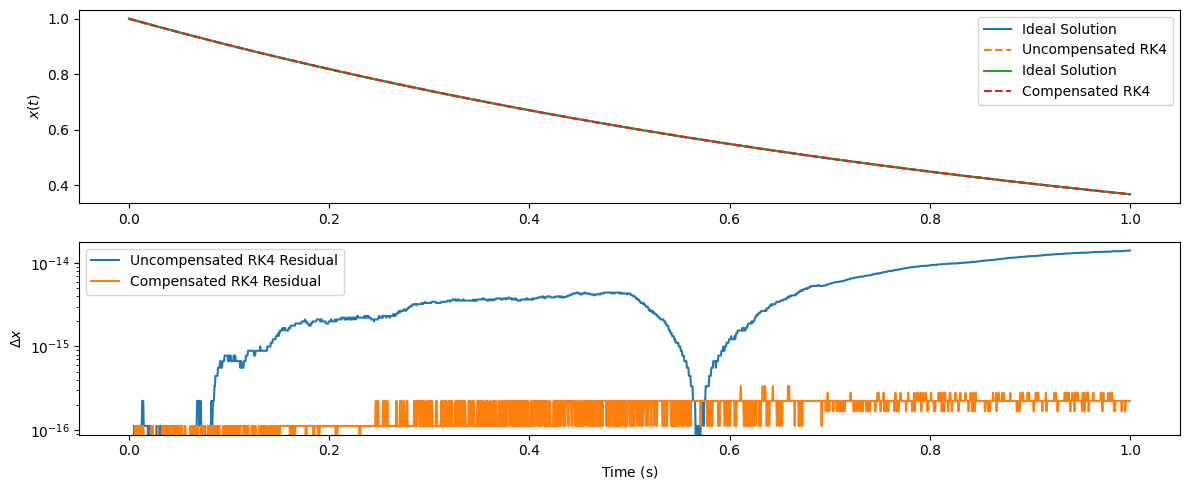

In [30]:
(f_state, f_time), sub_states = integrate_runge_kutta_4(exponential_fn, x0, t0, t1, machine_precision_dt)
(f_state_compensated, f_time_compensated), sub_states_compensated = integrate_runge_kutta_4_compensated(exponential_fn, x0, t0, t1, machine_precision_dt)

fig, axes = plot_trajectory(x0, sub_states, exponential_fn_solution, method_label="Uncompensated RK4")
fig, axes = plot_trajectory(x0, sub_states_compensated, exponential_fn_solution, axes=axes, method_label="Compensated RK4")
axes[1].set_yscale('log')

print(f"Error in Machine Precision Step (RK4): {(f_state - exponential_fn_solution(x0, t1)).abs().item()}")
print(f"Error in Machine Precision Step (RK4): {(f_state_compensated - exponential_fn_solution(x0, t1)).abs().item()}")

We have gained 2 orders of magnitude improvement, but this is only relevant once our step size is small enough that truncation error is the dominant; with neural networks we're rarely interested in machine precision accuracy and 64-bit floating point numbers are generally slower to compute with (and store).

Thus, for neural networks we try to minimise the arithmetic precision to improve the compute speed and reduce the memory bandwidth required. While 32-bit floats are the most common, mixed-precision is being used to focus on keeping precision for only the operations where it matters most while reducing the precision down to 16-bit floats or even 8-bit floats.

Let's look at the benefit of compensated summation on using 32-bit floats:

Timestep for machine precision (RK4 - float32): 0.07733710296035012
Error in Machine Precision Step (RK4): 1.283590447265226e-07
Error in Machine Precision Step (RK4): 9.855672233882729e-08


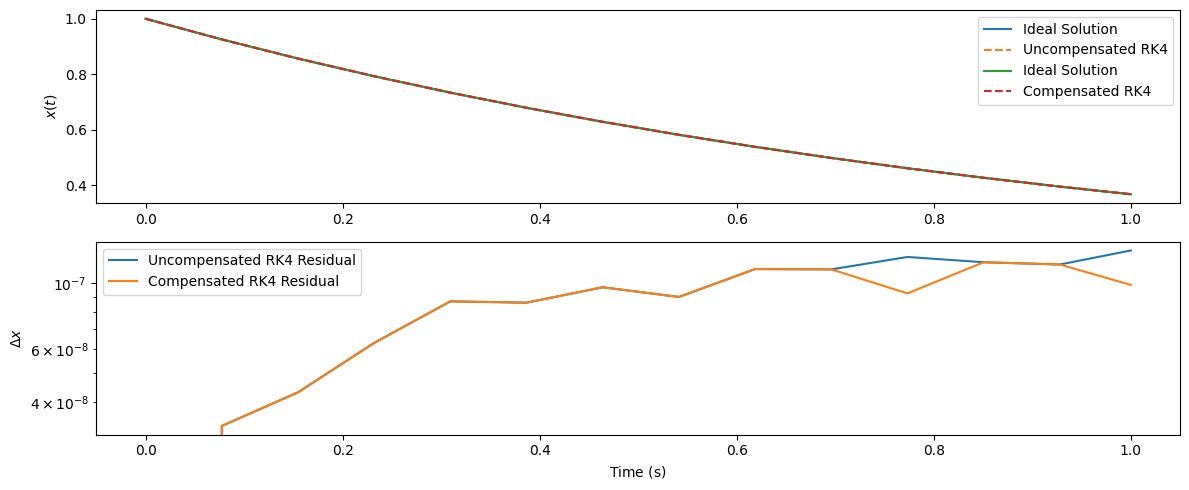

In [31]:
machine_precision_dt32 = dt * (torch.finfo(torch.float32).eps/error_in_full_step.item())**(1/4)
print(f"Timestep for machine precision (RK4 - float32): {machine_precision_dt32}")

(f_state, f_time), sub_states = integrate_runge_kutta_4(exponential_fn, x0.to(torch.float32), t0.to(torch.float32), t1.to(torch.float32), machine_precision_dt32)
(f_state_compensated, f_time_compensated), sub_states_compensated = integrate_runge_kutta_4_compensated(exponential_fn, x0.to(torch.float32), t0.to(torch.float32), t1.to(torch.float32), machine_precision_dt32)

fig, axes = plot_trajectory(x0, sub_states, exponential_fn_solution, method_label="Uncompensated RK4")
fig, axes = plot_trajectory(x0, sub_states_compensated, exponential_fn_solution, axes=axes, method_label="Compensated RK4")
axes[1].set_yscale('log')

print(f"Error in Machine Precision Step (RK4): {(f_state - exponential_fn_solution(x0, t1)).abs().item()}")
print(f"Error in Machine Precision Step (RK4): {(f_state_compensated - exponential_fn_solution(x0, t1)).abs().item()}")

As we can see, the gain is marginal, perhaps this is partially due to the less frequent step sizes, but also because the error in the arithmetic is entirely from the imprecision of the calculations themselves and not from truncation error.

## Wrapping Up

PyTorch uses the `torch.autograd.Function` class to define various functions and their gradients. This framework will also allow us to easily compose integrations as well as use the `torch.autograd.gradcheck` function to validate our implementation.

A good primer on how to correctly extend `torch.autograd.Function` can be found in the official documentation here: https://pytorch.org/docs/stable/notes/extending.html#extending-autograd

In [36]:
class IntegrateRK4(torch.autograd.Function):
    @staticmethod
    def forward(ctx, fn, x0, t0, t1, dt):
        """
        A general integration routine for solving an Initial Value Problem
        using the Classical Fourth-Order Method.
        
        Instead of naively summing the changes, we use compensated summation.
        
        :param fn: the function to be integrated
        :param initial_state: the initial state to integrate from
        :param initial_time: the initial time to integrate from
        :param final_time: the final time to integrate to
        :param timestep: the time increments to integrate with 
        :return: a tuple of ((the final state, the final time), the intermediates states [list]) 
        """
        # The names for the variables have been shortened for concision, and
        # to avoid overlap with variables in the outer scope
        # I have also left the annotations as they are invaluable for tracking the method. 
        c_time = t0.clone()
        c_state = x0.clone()
        
        # We'd like to track the whole trajectory, not just the final state, so we use a list to store the intermediate states and times
        i_states = [(c_state.clone(), c_time.clone())]
        
        # We write out the butcher tableau for easier computation
        butcher_tableau = torch.tensor([
            # c0, a00, a01, a02, a03
            [0.0, 0.0, 0.0, 0.0, 0.0],
            # c1, a10, a11, a12, a13
            [0.5, 0.5, 0.0, 0.0, 0.0],
            # c2, a20, a21, a22, a23
            [0.5, 0.0, 0.5, 0.0, 0.0],
            # c3, a30, a31, a32, a33
            [1.0, 0.0, 0.0, 1.0, 0.0],
            #     b0,  b1,  b2,  b3
            [0.0, 1/6, 2/6, 2/6, 1/6]
        ], dtype=x0.dtype, device=x0.device)
        # We see here that this method of writing out the tableau, while complete,
        # is inefficient given that so many entries are zero.
        # Ideally, we would have a more compressed format, but for our purposes,
        # this works.
        
        # At each step we repeat the same procedure with differing states and times 
        # (and step sizes for the last step), thus it makes sense to 
        # wrap everything in a local function which can be called repeatedly.
        def compute_step(state, time, step):
            # We need to store the intermediate stages
            k_stages = torch.stack([torch.zeros_like(time)]*(butcher_tableau.shape[1] - 1))
            # we subtract one since the last row is the final state
            for stage_index in range(butcher_tableau.shape[0] - 1):
                c_coeff, *a_coeff = butcher_tableau[stage_index]
                k_stages[stage_index] = fn(
                    # We use `compensated_sum` instead of sum in order to avoid truncation at each stage calculation
                    state + step * compensated_sum(k*a for k,a in zip(k_stages, a_coeff)), 
                    time + c_coeff * step
                )
            # We return the change in the state and the change in the time as we track partial sums
            # Again, we use `compensated_sum` to avoid truncation in the final stage calculations
            return step * compensated_sum(k*b for k,b in zip(k_stages, butcher_tableau[-1, 1:])), step
        
        # Initialise compensated sum terms
        # We don't need the partial sum variable as `c_state` and `c_time` take on that role
        truncated_bits_state = torch.zeros_like(c_state)
        truncated_bits_time  = torch.zeros_like(c_time)
        
        # We integrate as long as the current_time+dt is less than t1
        # Essentially, we want to stop the integration if taking another step
        # would lead to exceeding the final time
        while torch.any((c_time + dt) < t1):
            # To compute the change in state, we add the truncated bits back
            delta_state, delta_time = compute_step(c_state + truncated_bits_state, c_time + truncated_bits_time, dt)
            
            temporary = c_state + delta_state, c_time + delta_time
            truncated_bits_state = truncated_bits_state + torch.where(
                torch.abs(c_state) >= torch.abs(delta_state),
                (c_state - temporary[0]) + delta_state,
                (delta_state - temporary[0]) + c_state
            )
            truncated_bits_time = truncated_bits_time + torch.where(
                torch.abs(c_time) >= torch.abs(delta_time),
                (c_time - temporary[1]) + delta_time,
                (delta_time - temporary[1]) + c_time
            )
            c_state, c_time = temporary
            # We would like to store the intermediate states with the compensated partial sums
            i_states.append((c_state + truncated_bits_state, c_time + truncated_bits_time))
        delta_state, delta_time = compute_step(c_state + truncated_bits_state, c_time + truncated_bits_time, t1 - (c_time + truncated_bits_time))
        temporary = c_state + delta_state, c_time + delta_time
        truncated_bits_state = truncated_bits_state + torch.where(
            torch.abs(c_state) >= torch.abs(delta_state),
            (c_state - temporary[0]) + delta_state,
            (delta_state - temporary[0]) + c_state
        )
        truncated_bits_time = truncated_bits_time + torch.where(
            torch.abs(c_time) >= torch.abs(delta_time),
            (c_time - temporary[1]) + delta_time,
            (delta_time - temporary[1]) + c_time
        )
        c_state, c_time = temporary
        c_state, c_time = c_state + truncated_bits_state, c_time + truncated_bits_time
        i_states.append((c_state.clone(), c_time.clone()))
        
        ctx.save_for_backward((c_state, c_time, i_states))
        ctx.integration_function = fn        
        
        return (c_state, c_time), i_states

Error in Machine Precision Step (RK4): 2.220446049250313e-16


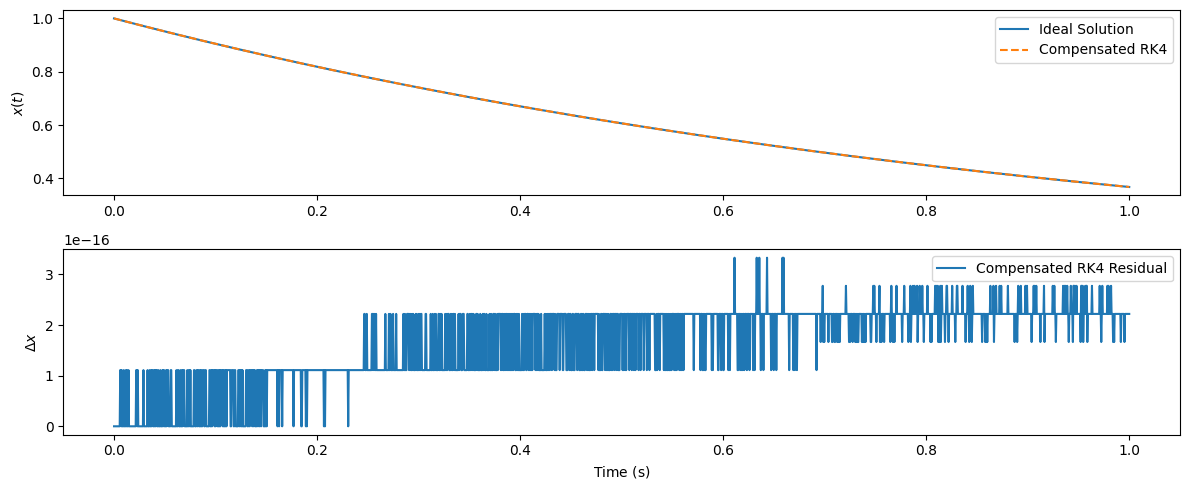

In [38]:
(f_state, f_time), sub_states = IntegrateRK4.apply(exponential_fn, x0, t0, t1, machine_precision_dt)

fig, axes = plot_trajectory(x0, sub_states, exponential_fn_solution, method_label="Compensated RK4")

print(f"Error in Machine Precision Step (RK4): {(f_state - exponential_fn_solution(x0, t1)).abs().item()}")

In the next notebook, we will take this function and show how an arbitrary butcher tableau may be used for integration. We will also discuss the modifications needed to implement an adaptive integration scheme.